In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font
plt.rc("hatch", color="k", linewidth=3)

HATCH = r"///"
N_DIVS = 30

## Small overlaps

In [2]:
# Conceptual visualization in 2D space

x_range = (-5, 5)
y_range = (-5, 5)
dx = np.linspace(*x_range, N_DIVS)
dy = np.linspace(*y_range, N_DIVS)
c_dx = np.linspace(*x_range, N_DIVS * 10)
c_dy = np.linspace(*y_range, N_DIVS * 10)


def sphere(x, y):
    return x ** 2 + y ** 2


def constraint(x, y, cx=3, cy=3):
    return (x - cx) ** 2 + (y - cy) ** 2


def upper_circle(x, cx=3, cy=3):
    val = np.maximum(3 - (x - cx) ** 2, 0)
    return cy + np.sqrt(val)


def lower_circle(x, cx=3, cy=3):
    val = np.maximum(3 - (x - cx) ** 2, 0)
    return cy - np.sqrt(val)


def plot_domain(ax: plt.Axes, cx=3, cy=3):
    # The whole domain [-5, 5] x [-5, 5] ==> mu([-5, 5] x [-5, 5]) = 100
    # The top γ (==> 0.1) quantile lies in the sphere
    # with the center at (0, 0) with the radius of √3
    # Let's say Γ ≒ 0.1 ==> center at (3, 3) with the radius of √3
    X, Y = np.meshgrid(dx, dy)
    Z = sphere(X, Y)
    level = np.linspace(Z.min(), Z.max(), 100)

    cmap = plt.cm.get_cmap("coolwarm")
    cont = ax.contourf(X, Y, Z, level, cmap=cmap.reversed())
    ax.set_xlim(*x_range)
    ax.set_ylim(*y_range)
    lines, labels = [], []
    
    kwargs = dict(facecolor="black", edgecolor="white", hatch=HATCH)
    label = "Infeasible domain"
    line = ax.fill_between(
        c_dx,
        upper_circle(c_dx, cx, cy),
        y_range[-1],
        alpha=0.4,
        linewidth=0.0,
        label=label,
        **kwargs
    )
    ax.fill_between(
        c_dx,
        y_range[0],
        lower_circle(c_dx, cx, cy),
        alpha=0.4,
        linewidth=0.0,
        **kwargs,
    )
    lines.append(line)
    labels.append(label)

    kwargs = dict(facecolor="yellow", edgecolor="black", hatch=r"|")
    label = "top-10% domain"
    line = ax.fill_between(
        c_dx,
        lower_circle(c_dx, 0, 0),
        upper_circle(c_dx, 0, 0),
        alpha=0.2,
        linewidth=0.0,
        label=label,
        **kwargs,
    )
    lines.append(line)
    labels.append(label)

    return cont, lines, labels

In [3]:
import ConfigSpace as CS
from optimizer import TPEOptimizer
from util.utils import get_logger


def fetch_data(cx, cy, max_evals=100):
    def obj_func(eval_config, cx=3, cy=3):
        x = eval_config["x"]
        y = eval_config["y"]
        return {"loss": sphere(x, y), "constraint": constraint(x, y, cx, cy)}


    config_space = CS.ConfigurationSpace()
    config_space.add_hyperparameters([
        CS.UniformFloatHyperparameter("x", lower=x_range[0], upper=x_range[1]),
        CS.UniformFloatHyperparameter("y", lower=y_range[0], upper=y_range[1])   
    ])

    name = "small-overlap-ours"
    logger = get_logger(file_name=name, logger_name=name)
    kwargs = dict(
        obj_func=lambda eval_config: obj_func(eval_config, cx=cx, cy=cy),
        config_space=config_space,
        max_evals=max_evals,
        constraints={"constraint": 3.0},
        seed=0,
    )
    opt_ours = TPEOptimizer(
        **kwargs, resultfile=name,
    )
    opt_ours.optimize(logger)

    name = "small-overlap-naive"
    logger = get_logger(file_name=name, logger_name=name)
    opt_naive = TPEOptimizer(
        **kwargs, resultfile=name, naive_mode=True
    )
    opt_naive.optimize(logger)
    
    return opt_naive.fetch_observations(), opt_ours.fetch_observations()

In [8]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(20, 8),
    gridspec_kw={"wspace": 0.025, "hspace": 0.1},
    sharey=True,
    sharex=True,
)

max_evals = 50
color_kwargs = dict(
    s=100,
    cmap="gray",
    c=np.arange(max_evals),
    edgecolors="black",
    linewidths=0.5,
    alpha=0.7,
)
for r, center in enumerate([0.5, 2.3]):
    data_naive, data_ours = fetch_data(cx=center, cy=center, max_evals=max_evals)

    ax = axes[r][0]
    if r == 0:
        ax.set_title("Naïve Extension", fontsize=32)
        ax.set_ylabel("Large overlap", fontsize=32)
    else:
        ax.set_ylabel("Small overlap", fontsize=32)

    plot_domain(ax, cx=center, cy=center)
    ax.scatter(data_naive["x"], data_naive["y"], **color_kwargs)

    ax = axes[r][1]
    if r == 0:
        ax.set_title("Our method")

    cont, lines, labels = plot_domain(ax, cx=center, cy=center)
    label = "Observations"
    line = ax.scatter(data_ours["x"], data_ours["y"], label=label, **color_kwargs)
    labels.append(label)
    lines.append(line)

cbar = fig.colorbar(cont, ax=axes.ravel().tolist(), pad=0.0125)
cbar.ax.set_title("$f(x, y)$", y=1.01, fontsize=32)
axes[1][0].legend(
    handles=lines,
    loc='upper center',
    labels=labels,
    fontsize=32,
    bbox_to_anchor=(1.0125, -0.12),
    fancybox=False,
    shadow=False,
    ncol=len(labels)
)

# add some info to the colorbar
labels = [""] * len(cont.levels)
labels[20], labels[-20] = "$\Longrightarrow$ Better", "Worse $\Longleftarrow$"
cbar.set_ticks(cont.levels)
cbar.set_ticklabels(labels, fontsize=32)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=270, va="center")
cbar.ax.tick_params(size=0)

plt.savefig("small-overlap.pdf", bbox_inches='tight')

## Vanished constraints

In [33]:
# Conceptual visualization in 2D space

x_range = (-5, 5)
y_range = (-5, 5)
dx = np.linspace(*x_range, N_DIVS)
dy = np.linspace(*y_range, N_DIVS)
c_center, o_center = 1, -2


def sphere(x, y):
    return (x - o_center) ** 2 + (y - o_center) ** 2


def constraint(x, y):
    # radius 4: 16pi ~ 50%
    # radius 2: 4pi ~ 12.5%
    return (x - c_center) ** 2 + (y - c_center) ** 2


def upper_circle(x, cx, cy, rad):
    val = np.maximum(rad ** 2 - (x - cx) ** 2, 0)
    return cy + np.sqrt(val)


def lower_circle(x, cx, cy, rad):
    val = np.maximum(rad ** 2 - (x - cx) ** 2, 0)
    return cy - np.sqrt(val)


def compute_pi(opt: TPEOptimizer, X, Y):
    config_cands = [X.flatten(), Y.flatten()]
    pi = opt.tpe_samplers[opt.metric_name].compute_probability_improvement(
        config_cands
    )
    for obj_name in opt.constraints.keys():
        if opt.constraints[obj_name] == np.inf:
            continue

        pi += opt.tpe_samplers[obj_name].compute_probability_improvement(
            config_cands
        )

    return pi.reshape(X.shape)


def plot_domain(ax: plt.Axes, opt, rad):
    X, Y = np.meshgrid(dx, dy)
    Z = compute_pi(opt, X, Y)
    level = np.linspace(Z.min(), Z.max(), 100)

    sq3 = np.sqrt(3)
    cont = ax.contourf(X, Y, Z, level, cmap="coolwarm")
    ax.set_xlim(*x_range)
    ax.set_ylim(*y_range)

    kwargs = dict(facecolor="black", edgecolor="white", hatch=HATCH)
    lines, labels = [], []

    label = "Infeasible domain"
    uc = upper_circle(c_dx, c_center, c_center, rad)
    lc = lower_circle(c_dx, c_center, c_center, rad)
    line = ax.fill_between(
        c_dx,
        uc,
        y_range[-1],
        alpha=0.4,
        linewidth=0.0,
        label=label,
        **kwargs,
    )
    ax.fill_between(
        c_dx,
        lc,
        y_range[0],
        lower_circle(c_dx, c_center, c_center, rad),
        alpha=0.4,
        linewidth=0.0,
        **kwargs,
    )
    lines.append(line)
    labels.append(label)

    kwargs = dict(facecolor="yellow", edgecolor="black", hatch=r"|")
    label = "top-10% domain"
    line = ax.fill_between(
        c_dx,
        lower_circle(c_dx, o_center, o_center, sq3),
        upper_circle(c_dx, o_center, o_center, sq3),
        alpha=0.2,
        linewidth=0.0,
        label=label,
        **kwargs,
    )
    lines.append(line)
    labels.append(label)

    return cont, lines, labels

In [34]:
def fetch_opt(rad, max_evals=100, seed=0):
    def obj_func(eval_config):
        x = eval_config["x"]
        y = eval_config["y"]
        return {"loss": sphere(x, y), "constraint": constraint(x, y)}


    config_space = CS.ConfigurationSpace()
    config_space.add_hyperparameters([
        CS.UniformFloatHyperparameter("x", lower=x_range[0], upper=x_range[1]),
        CS.UniformFloatHyperparameter("y", lower=y_range[0], upper=y_range[1])   
    ])

    name = "vanished-constraint-ours"
    logger = get_logger(file_name=name, logger_name=name)
    kwargs = dict(
        obj_func=obj_func,
        config_space=config_space,
        max_evals=max_evals,
        n_init=max_evals,
        constraints={"constraint": rad ** 2},
        seed=seed,
    )
    opt_ours = TPEOptimizer(
        **kwargs, resultfile=name,
    )
    opt_ours.optimize(logger)

    name = "vanished-constraint-naive"
    logger = get_logger(file_name=name, logger_name=name)
    opt_naive = TPEOptimizer(
        **kwargs, resultfile=name, naive_mode=True
    )
    opt_naive.optimize(logger)
    
    return opt_naive, opt_ours

naive-Tight: 0.02
ours-Tight: 0.285
naive-Loose: 0.02
ours-Loose: 0.025


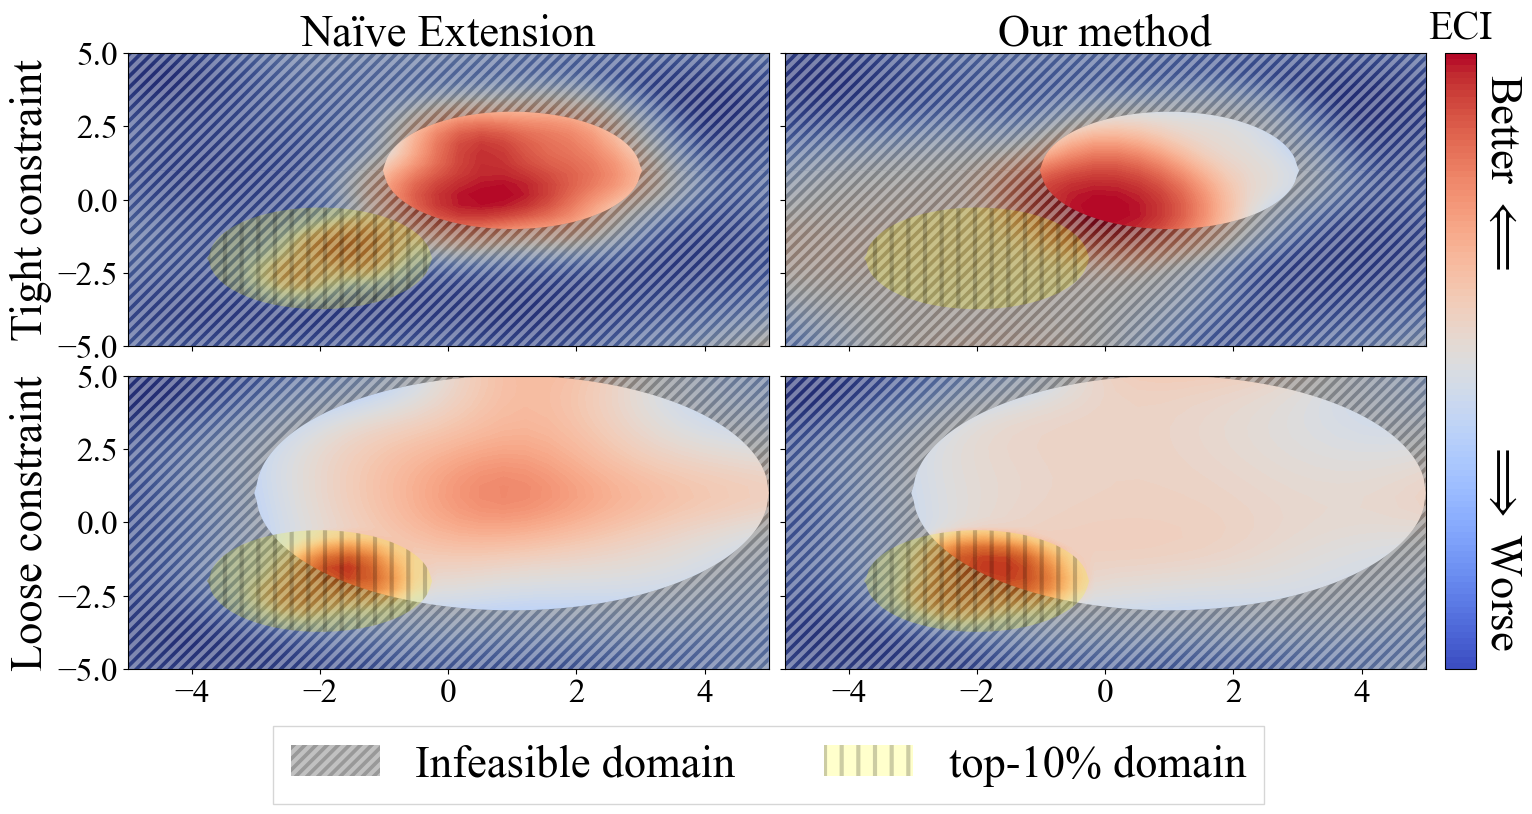

In [37]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(20, 8),
    gridspec_kw={"wspace": 0.025, "hspace": 0.1},
    sharey=True,
    sharex=True,
)

for r, rad in enumerate([2, 4]):
    opt_naive, opt_ours = fetch_opt(rad, max_evals=200, seed=42)

    ax = axes[r][0]
    tightness = "Tight" if r == 0 else "Loose"
    ax.set_ylabel(f"{tightness} constraint", fontsize=32)
    if r == 0:
        ax.set_title("Naïve Extension", fontsize=32)
    
    q = opt_naive.tpe_samplers[opt_naive.metric_name].percentile
    print(f"naive-{tightness}: {q}")
    plot_domain(ax, opt=opt_naive, rad=rad)

    ax = axes[r][1]
    if r == 0:
        ax.set_title("Our method", fontsize=32)

    q = opt_ours.tpe_samplers[opt_ours.metric_name].percentile
    print(f"ours-{tightness}: {q}")
    cont, lines, labels = plot_domain(ax, opt=opt_ours, rad=rad)


cbar = fig.colorbar(cont, ax=axes.ravel().tolist(), pad=0.0125)
axes[1][0].legend(
    handles=lines,
    loc='upper center',
    labels=labels,
    fontsize=32,
    bbox_to_anchor=(1.0, -0.12),
    fancybox=False,
    shadow=False,
    ncol=len(labels)
)

# add some info to the colorbar
labels = [""] * len(cont.levels)
labels[20], labels[-20] = "$\Longrightarrow$ Worse", "Better $\Longleftarrow$"
cbar.set_ticks(cont.levels)
cbar.set_ticklabels(labels, fontsize=32)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=270, va="center")
cbar.ax.tick_params(size=0)

cbar.ax.set_title("ECI", y=1.01)
plt.savefig("vanished-constraint.pdf", bbox_inches='tight')